In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from keras import backend as K

from keras.models import load_model



In [2]:
import util

In [3]:
from keras.applications.densenet import DenseNet121

In [4]:
batch_size = 64

In [5]:
train_df = pd.read_csv("train-small.csv")
valid_df = pd.read_csv("valid-small.csv")

test_df = pd.read_csv("test.csv")

train_df.head()

,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00008270_015.png,0,0,0,0,0,0,0,0,0,0,0,8270,0,0,0
1,00029855_001.png,1,0,0,0,1,0,0,0,1,0,0,29855,0,0,0
2,00001297_000.png,0,0,0,0,0,0,0,0,0,0,0,1297,1,0,0
3,00012359_002.png,0,0,0,0,0,0,0,0,0,0,0,12359,0,0,0
4,00017951_001.png,0,0,0,0,0,0,0,0,1,0,0,17951,0,0,0


In [6]:
import tensorflow as tf

In [6]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<p>
<ul>
    <li> Make use of python's set.intersection() function. </li>
</ul>
</p>

In [8]:
# Checking for Data Leakage
def check_for_leakage(df1, df2, patient_col):
    
    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    leakage = len(patients_in_both_groups) > 0
    
    return leakage

In [9]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'PatientId')))
print("leakage between valid and test: {}".format(check_for_leakage(valid_df, test_df, 'PatientId')))

leakage between train and test: False
leakage between valid and test: False


In [7]:
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    samplewise_center=True,
    samplewise_std_normalization= True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False)

train_generator = datagen.flow_from_dataframe(
    dataframe= train_df,
    directory= "Images/",
    x_col='Image',
    y_col=labels,
    target_size=(320, 320),
    batch_size=batch_size,
     class_mode="raw"
  
)

val_generator = datagen.flow_from_dataframe(
    dataframe= valid_df,
    directory= "Images/",
    x_col='Image',
    y_col=labels,
    target_size=(320, 320),
    batch_size=batch_size,
     class_mode="raw"
  
)

test_generator = datagen.flow_from_dataframe(
    dataframe= test_df,
    directory= "Images/",
    x_col='Image',
    y_col=labels,
    target_size=(320, 320),
    batch_size=batch_size,
    class_mode = "raw", 
    shuffle=False )


Found 1000 validated image filenames.
Found 200 validated image filenames.
Found 420 validated image filenames.


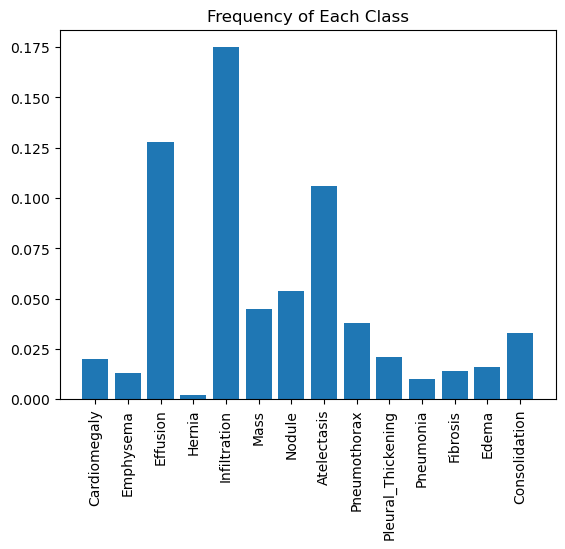

In [8]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

In [12]:
def compute_class_freqs(labels):
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

In [13]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.02 , 0.013, 0.128, 0.002, 0.175, 0.045, 0.054, 0.106, 0.038,
       0.021, 0.01 , 0.014, 0.016, 0.033])

In [14]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [15]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
   
    def weighted_loss(y_true, y_pred):
    
        loss = 0.0

        for i in range(len(pos_weights)):
            loss_pos = -1 * tf.reduce_mean(pos_weights[i] * y_true[:, i] * tf.math.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * tf.reduce_mean(neg_weights[i] * (1 - y_true[:, i]) * tf.math.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss
    
        ### END CODE HERE ###
    return weighted_loss

In [12]:
base_model = DenseNet121(weights='densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy')

<a name='4'></a>
## 4 Training [optional]

**Note** that we have already provided a pre-trained model, so you don't need to run the following training cell (as it will take some time).

With our model ready for training, we will use the `model.fit()` function in Keras to train our model. 
- We are training on a small subset of the dataset (~1%).  


In [17]:
# """
# OPTIONAL: uncomment this code to practice training the model.
# This is optional because we have loaded pre-trained weights after this.
# """

#history = model.fit(train_generator, 
                               validation_data=val_generator,
                        
                               epochs = 5)
#plt.plot(history.history['loss'])
##plt.ylabel("loss")
#plt.xlabel("epoch")
#plt.title("Training Loss Curve")
#plt.show()

IndentationError: unexpected indent (2502662138.py, line 7)

In [13]:
model.load_weights("pretrained_model.h5")

In [23]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ zero_padding2d[0… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, None,      │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, None,      │          0 │ conv2_block1_0_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, None,      │          0 │ pool1[0][0],      │
│ (Concatenate)       │ None, 96)         │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, None,      │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, None,      │          0 │ conv2_block2_0_b… │
│ (Activation)        │ None, 96)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, None,      │     12,288 │ conv2_block2_0_r

 Total params: 7,051,854 (26.90 MB)

 Trainable params: 6,968,206 (26.58 MB)

 Non-trainable params: 83,648 (326.75 KB)

C:\Users\Uskou\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 86s 11s/step


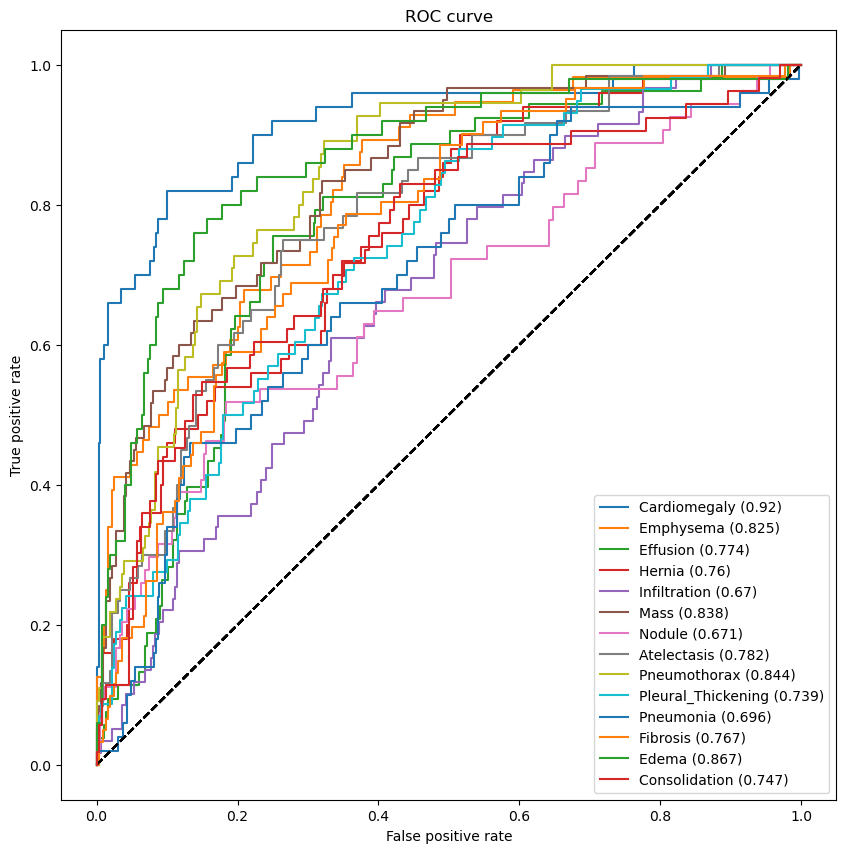

In [14]:
predicted_vals = model.predict(test_generator)
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

For reference, here's the AUC figure from the ChexNeXt paper which includes AUC values for their model as well as radiologists on this dataset:

<img src="https://journals.plos.org/plosmedicine/article/figure/image?size=large&id=10.1371/journal.pmed.1002686.t001" width="80%">


In [102]:
df = pd.read_csv("train-small.csv")
IMAGE_DIR = "Images/"

#only show the lables with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

In [15]:
from keras.preprocessing import image

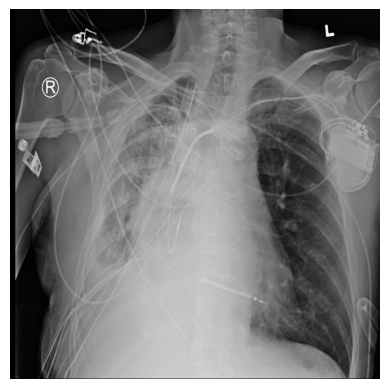

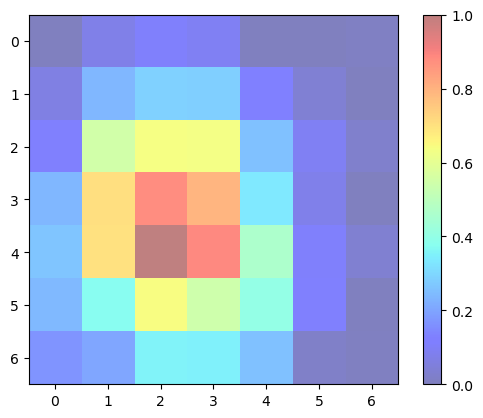

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Received array with shape: (1,)

In [16]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.models import Model

def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return tf.keras.applications.densenet.preprocess_input(img_array)



def get_gradcam(model, image_path, layer_name):
    img = preprocess_image(image_path)
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        class_idx = tf.argmax(predictions[0])

    output = conv_outputs[0]
    grads = tape.gradient(predictions, conv_outputs)[0]
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    heatmap = np.maximum(cam, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy(), class_idx.numpy()



# Path to the image
image_path = r"C:\Users\Uskou\Images\00000013_010.png"
preprocessed_image = preprocess_image(image_path)

# Layer name for Grad-CAM
layer_name = 'conv5_block16_concat'

# Generate Grad-CAM and get predicted class index
heatmap, class_idx = get_gradcam(model, image_path, layer_name)

# Display the image
plt.imshow(load_img(image_path))
plt.axis('off')
plt.show()

# Display the heatmap
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.colorbar()
plt.show()

# Print the predicted class and its index
print('Predicted Class:', decode_predictions(np.array([class_idx]))[0][0][1])
print('Predicted Class Index:', class_idx)

In [108]:
img = image.load_img(r"C:\Users\Uskou\Images\00005410_000.png", target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Predict using the preprocessed image
predictions = model.predict(img_array)
print(predictions)


def example(image):
            image = image.reshape((-1, 224, 224, 3)),
            prediction = model.predict(image).flatten(),
            return {class_names[i]: float(prediction[i]) for i in range(4)}
class_names = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
[[1.000000e+00 0.000000e+00 1.000000e+00 9.966894e-01 1.489017e-32
  0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00 0.000000e+00 1.000000e+00 0.000000e+00]]


In [25]:
class_names = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

In [105]:
import gradio as gr

In [27]:
def custom_decode_predictions(predictions, class_labels):
    
    decoded_predictions = []
    for pred in predictions:
        # Get indices of top predicted classes
        top_indices = pred.argsort()[-3:][::-1]  # Change 5 to the number of top classes you want to retrieve
        # Decode each top predicted class
        decoded_pred = [(class_labels[i], pred[i]) for i in top_indices]
        decoded_predictions.append(decoded_pred)
    return decoded_predictions

def classify_image(img):
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)


    predictions1 = model.predict(img_array)
    decoded_predictions = custom_decode_predictions(predictions1, class_names)
    return decoded_predictions

# Gradio interface
iface = gr.Interface(
    fn=classify_image, 
    inputs="image", 
    outputs="text", 
    title="Image Classification",
    description="Classify images using your pre-trained model."
)

# Launch the interface
iface.launch(share = True)

Running on local URL:  http://127.0.0.1:7868
Running on public URL: https://cb47643531a27d2505.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
